In [55]:
import os
import dotenv
import unicodedata
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as pltgr

def limpiaTexto(texto):
    if not isinstance(texto, str):
        return texto
    # Proteger la ñ y Ñ con un marcador temporal
    texto = texto.replace('ñ', '__enie__').replace('Ñ', '__ENIE__')
    # Quitar tildes
    texto = ''.join(
        c for c in unicodedata.normalize('NFD', texto)
        if unicodedata.category(c) != 'Mn'
    )
    # Restaurar la ñ y Ñ
    return texto.replace('__enie__', 'ñ').replace('__ENIE__', 'Ñ')
def limpiaComunas(texto):
    if not isinstance(texto, str):
        return texto
    coma_pos = texto.find(",")
    if coma_pos != -1:
        tfinal = texto[:coma_pos].lower()
        x = tfinal.find("de chile")
        if x != -1:
            tfinal = tfinal[:x].strip()
        return tfinal
    elif texto.lower().find("santiago") != -1:
        return texto.lower().replace("santiago -", "").strip()
    elif texto.lower().find("- santiago") != -1:
        return texto.lower().replace("- santiago", "").strip()
    return texto.lower()
dotenv.load_dotenv()
path_csv = os.getenv("CSV_CHILETRABAJOS")
path_csv2 = os.getenv("CSV_COMPUTRABAJO")
path_csv3 = os.getenv("CSV_INDEED")

try:
    df = pd.read_csv(path_csv,sep=";",encoding="utf-8")
    print("datos de 'chiletrabajos.com' cargados")
    # Limpia caracteres de ofertas
    df['Oferta'] = df['Oferta'].apply(limpiaTexto)
    display(df.head())
except Exception as e:
        print(f"error :{e}")
        
try:
    df2 = pd.read_csv(path_csv2,sep=",",encoding="utf-8")
    print("datos 'computrabajo.com' cargados")
    df2['Cargo'] = df2['Cargo'].apply(limpiaTexto)
    display(df2.head())
except Exception as e:
        print(f"error :{e}")

try:
    df3 = pd.read_csv(path_csv3,sep=";",encoding="utf-8")
    print("datos 'indeed.com' cargados")
    display(df3.head())
except Exception as e:
        print(f"error :{e}")

datos de 'chiletrabajos.com' cargados


,Oferta,Salario,Beneficios,Empresa,Descripcion,Ubicacion,Fecha_Publicacion,Fecha_Expiracion
0,INGENIERO DE SOFTWARE – BLAZOR WEBASSEMBLY .NE...,a convenir,-La empresa paga o copaga una cobertura de sal...,Grupo-O2,En GRUPO O2 busca Ingeniero de Software – Blaz...,Santiago,2025-03-24 10:24:32,2025-06-07 (en 75 días)
1,INGENIERO DE SOFTWARE – FRONTEND REACT Y BACKE...,a convenir,-La empresa paga o copaga una cobertura de sal...,GRUPO-o2,En GRUPO O2 busca Ingeniero de Software – Fron...,Santiago,2025-03-24 10:28:38,2025-06-07 (en 75 días)
2,AYUDANTE CONDUCTOR,NaN,-¡La salud es lo más importante! La empresa pa...,Reclutamiento XR3,En XR3 nos encontramos buscando a nuestro prox...,Illapel,2025-03-22 12:02:01,2025-06-05 (en 73 días)
3,DISEÑADOR UX UI (REMOTO),NaN,-La empresa paga o copaga una cobertura de sal...,Kibernum,¡Únete a nuestro equipo como Diseñador UX UI p...,Santiago,2025-03-21 11:42:15,2025-06-04 (en 72 días)
4,INGENIERO CLOUD OPS,Negociable,-La empresa paga o copaga una cobertura de sal...,Kabeli Selección,Kabeli se encuentra en búsqueda de un Ingenier...,Santiago,2025-03-21 16:03:14,2025-06-04 (en 72 días)


datos 'computrabajo.com' cargados


,Salario,Empresa,Comuna,Región,Cargo
0,NaN,Page Personnel,Santiago - Providencia,R.Metropolitana,Desarrollador Fullstack Controller - Java Spri...
1,NaN,MM ASESORIAS,Santiago Centro,R.Metropolitana,Desarrollador Web
2,2000000.0,Page Personnel,Santiago Centro,R.Metropolitana,Especialista Desarrollador - Proyecto
3,1700000.0,Perceptual Consultores Ltda.,Santiago Centro,R.Metropolitana,Programador Mobile - Android/Java
4,NaN,MM ASESORIAS,Santiago Centro,R.Metropolitana,Desarrollador .NET Senior


datos 'indeed.com' cargados


,oferta,salario,empresa,descripcion,ubicacion
0,"""Asistente de informática (Santiago)""",NaN,Salmonjobs,Estamos en búsqueda de un/a Asistente de Infor...,"Santiago de Chile, Región Metropolitana"
1,"""Practica profesional Informática""",NaN,Applicant AI,Responsabilidades del practicante:\r\nConfigur...,"Santiago de Chile, Región Metropolitana"
2,"""ENCARGADO TECNOLOGIA E INFORMATICA (TI)""",NaN,Confidencial,REALIZAR BACKUP\r\nSUPERVISAR CONEXIONES\r\nCO...,"Santiago de Chile, Región Metropolitana"
3,"""Soporte Informático""",NaN,NEWREST CHILE,NEWREST empresa multinacional francesa de serv...,"Puerto Montt, Los Lagos"
4,"""Técnico en soporte Informático – Remoto (Ofe...",NaN,CLÍNICA MEDICAL HOME,Clínica medical home nos encontramos en búsque...,"Santiago de Chile, Región Metropolitana"


In [56]:
# Contamos las ofertas por ubicación en cada dataframe
tabla_ciudades_ct = df['Ubicacion'].value_counts().reset_index()
tabla_ciudades_ct.columns = ['Ciudad/Comuna', 'Cantidad_Ofertas']
tabla_ciudades_ct['Ciudad/Comuna'] = tabla_ciudades_ct['Ciudad/Comuna'].apply(limpiaComunas)

tabla_ciudades_comput = df2['Comuna'].value_counts().reset_index()
tabla_ciudades_comput.columns = ['Ciudad/Comuna', 'Cantidad_Ofertas']
tabla_ciudades_comput['Ciudad/Comuna'] = tabla_ciudades_comput['Ciudad/Comuna'].apply(limpiaComunas)

tabla_ciudades_indeed = df3['ubicacion'].value_counts().reset_index()
tabla_ciudades_indeed.columns = ['Ciudad/Comuna', 'Cantidad_Ofertas']
tabla_ciudades_indeed['Ciudad/Comuna'] = tabla_ciudades_indeed['Ciudad/Comuna'].apply(limpiaComunas)
tabla_ciudades_total = pd.concat([tabla_ciudades_ct, tabla_ciudades_comput, tabla_ciudades_indeed], ignore_index=True)
# Agrupamos por ciudad y sumamos la cantidad de ofertas
tabla_ciudades_total = tabla_ciudades_total.groupby('Ciudad/Comuna', as_index=False).sum()
# Ordenamos por cantidad de ofertas de mayor a menor
tabla_ciudades_total = tabla_ciudades_total.sort_values(by='Cantidad_Ofertas', ascending=False)

# Mostramos la tabla
print("Total de ofertas por ciudad\n")
print(print(tabla_ciudades_total.to_string(index=False)))



Total de ofertas por ciudad

  Ciudad/Comuna  Cantidad_Ofertas
       santiago              1205
    antofagasta                54
     concepción                53
     las condes                46
     valparaíso                38
santiago centro                30
    providencia                25
       rancagua                22
        iquique                16
   puerto montt                16
        copiapó                13
       vitacura                12
      la serena                11
         calama                10
         temuco                10
          talca                 9
       valdivia                 8
     huechuraba                 7
    los ángeles                 7
       coquimbo                 7
   punta arenas                 7
   lo barnechea                 6
        illapel                 6
      quilicura                 6
        chillán                 6
   viña del mar                 6
          arica                 6
         osorno    

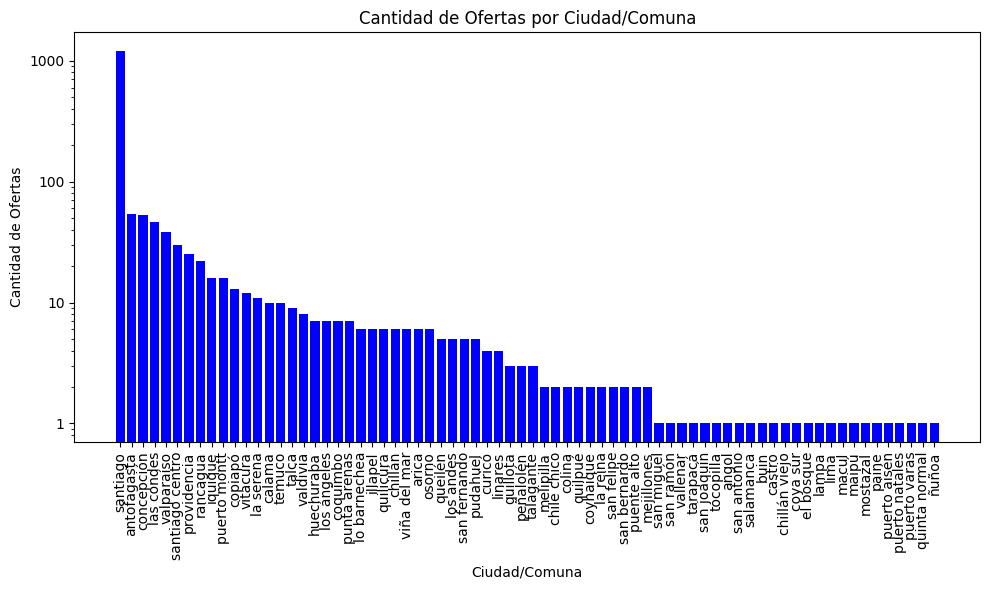

In [76]:
from matplotlib.ticker import FuncFormatter
pltgr.figure(figsize=(10, 6))
pltgr.bar(tabla_ciudades_total['Ciudad/Comuna'], tabla_ciudades_total['Cantidad_Ofertas'], color='blue')
pltgr.yscale('log')  # Escala logarítmica en el eje y

# Personalizar las etiquetas del eje y
formatter = FuncFormatter(lambda y, _: f'{int(y)}')
pltgr.gca().yaxis.set_major_formatter(formatter)
pltgr.xlabel('Ciudad/Comuna')
pltgr.ylabel('Cantidad de Ofertas')
pltgr.title('Cantidad de Ofertas por Ciudad/Comuna')
pltgr.xticks(rotation=90)
pltgr.tight_layout()
pltgr.show()

In [88]:
def clasificar_puesto(oferta):
    oferta = str(oferta).lower()
    if ('fullstack' or 'full stack'or 'full-stack') in oferta:
        return 'Fullstack'
    elif ('frontend' or 'front end' or 'front-end') in oferta:
        return 'Frontend'
    elif ('backend' or 'back end' or 'back-end' or 'sql') in oferta:
        return 'Backend'
    elif 'analista' in oferta:
        return 'Analista'
    elif 'devops' in oferta:
        return 'DevOps'
    elif ('qa' or 'tester') in oferta:
        return 'QA'
    elif ('data' or 'analista de datos' or 'bigdata' or 'big data' or 'datos' or 'data scientist') in oferta:
        return 'Data Scientist'
    elif ('ciberseguridad'or 'seguridad' or 'ethical hacking') in oferta:
        return 'Ciberseguridad'
    elif ('mobile' or 'movil'or 'android' or 'ios') in oferta:
        return 'Mobile'
    elif ('ux' or 'ui') in oferta:
        return 'UX/UI'
    elif ('machine learning engineer' or 'ia') in oferta:
        return 'Ingeniero de IA'
    elif ('arquitecto' or 'arquitecta' or 'arquitecto de software') in oferta:
        return 'Arquitecto de Software'
    elif ('consultor' or 'consultora' or 'consulting') in oferta:
        return 'Consultor'
    elif ('lider' or 'scrum master' or 'scrum-master' or 'jefe de proyectos' or 'jefe de proyecto' or 'proyect manager') in oferta:
        return 'Lider de proyecto'
    elif ('desarrollador' or 'developer' or 'programador' or 'ingeniero de software' or 'ejecucion') in oferta:
        return 'Developer'
    elif ('soporte' or 'mantenimiento')in oferta:
        return 'Soporte Técnico'
    elif 'cloud' in oferta:
        return 'Cloud'
    elif 'tecnico' in oferta:
        return 'Técnico'
    elif 'practica' in oferta:
        return 'Práctica Profesional'
    elif ('administrador' or 'gestor') in oferta:
        return 'Administrador'
    elif ('redes' or 'comunicaciones' or 'telecomunicaciones') in oferta:
        return 'Redes'
    elif ('business intelligence' or 'bi') in oferta:
        return 'Business Intelligence'
    elif ('sistemas' or 'infraestructura' or 'infraestructura de sistemas') in oferta:
        return 'Especialista en Sistemas'
    
    else:
        return 'Otros'

df['Puesto'] = df['Oferta'].apply(clasificar_puesto)
df2['Puesto'] = df2['Cargo'].apply(clasificar_puesto)
df3['Puesto'] = df3['oferta'].apply(clasificar_puesto)
tabla_puestos_indeed = df3['Puesto'].value_counts().reset_index()
tabla_puestos_comput = df2['Puesto'].value_counts().reset_index()
tabla_puestos = df['Puesto'].value_counts().reset_index()
tabla_puestos.columns = ['Puesto', 'Cantidad_Ofertas']
tabla_puestos_comput.columns = ['Puesto', 'Cantidad_Ofertas']
tabla_puestos_indeed.columns = ['Puesto', 'Cantidad_Ofertas']


In [89]:
# Concatenamos ambas tablas
tabla_total = pd.concat([tabla_puestos, tabla_puestos_comput,tabla_puestos_indeed])

# Agrupamos por 'Puesto' y sumamos las ofertas
tabla_total = tabla_total.groupby('Puesto', as_index=False).sum()

# Ordenamos de mayor a menor cantidad de ofertas
tabla_total = tabla_total.sort_values(by='Cantidad_Ofertas', ascending=False)

# Mostramos la tabla final
print("Total de ofertas por puesto (sumando Chiletrabajos y Computrabajo)\n")
tabla_total = tabla_total.sort_values(by='Puesto', ascending=True)
print(tabla_total.to_string(index=False))

Total de ofertas por puesto (sumando Chiletrabajos y Computrabajo)

                  Puesto  Cantidad_Ofertas
           Administrador                39
                Analista               184
  Arquitecto de Software                18
                 Backend                32
   Business Intelligence                 1
          Ciberseguridad                21
                   Cloud                34
               Consultor                45
          Data Scientist                33
                  DevOps                17
               Developer               182
Especialista en Sistemas                16
                Frontend                32
               Fullstack                45
       Lider de proyecto                26
                  Mobile                10
                   Otros              1016
    Práctica Profesional                46
                      QA                12
                   Redes                32
         Soporte Técnico     

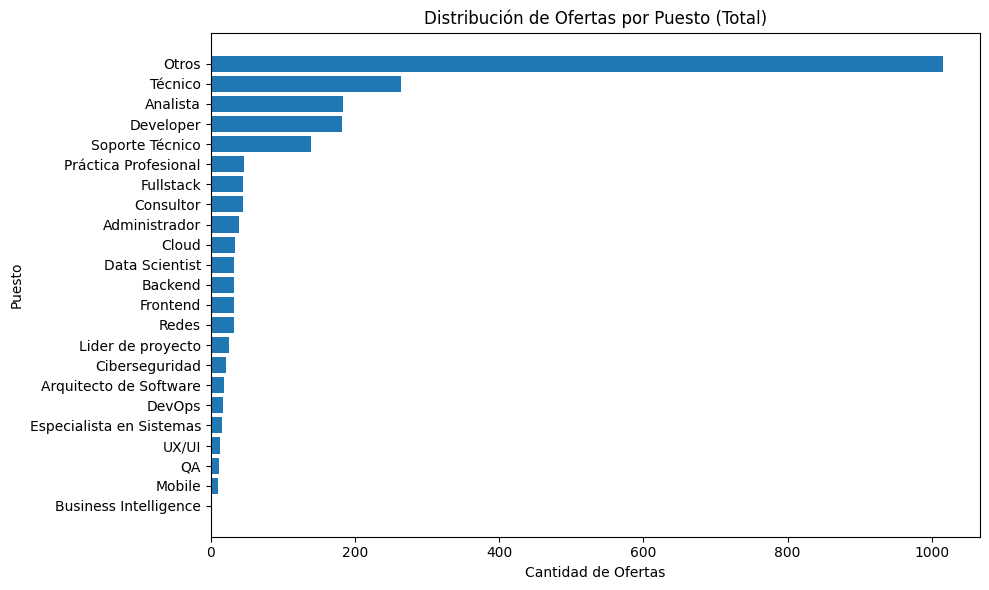

In [90]:
# Pie chart de puestos
tabla_total_sorted = tabla_total.sort_values(by='Cantidad_Ofertas', ascending=True)

pltgr.figure(figsize=(10, 6))
pltgr.barh(tabla_total_sorted['Puesto'], tabla_total_sorted['Cantidad_Ofertas'])
pltgr.xlabel('Cantidad de Ofertas')
pltgr.ylabel('Puesto')
pltgr.title('Distribución de Ofertas por Puesto (Total)')
pltgr.tight_layout()
pltgr.show()




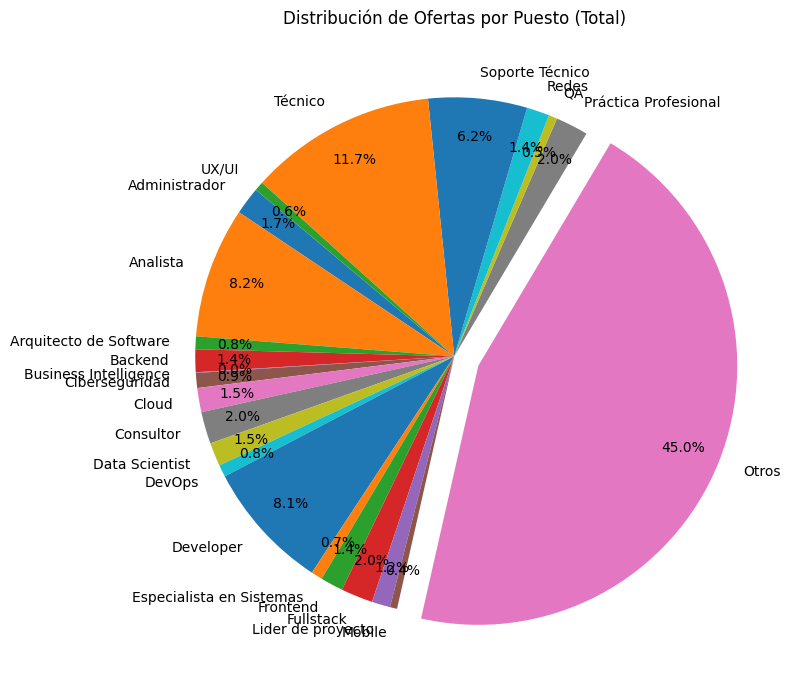

In [91]:

labels = tabla_total['Puesto']
sizes = tabla_total['Cantidad_Ofertas']

# Explode la categoría más grande (opcional)
explode = [0.1 if s == max(sizes) else 0 for s in sizes]

pltgr.figure(figsize=(8, 8))
pltgr.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    explode=explode,
    pctdistance=0.85,
    labeldistance=1.1
)
pltgr.title('Distribución de Ofertas por Puesto (Total)')
pltgr.tight_layout()
pltgr.show()